In [3]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

import sklearn
from sklearn.metrics.ranking import roc_auc_score
from sklearn.metrics import roc_curve, auc
import random

In [4]:
image_set_csv = 'CheXpert-v1.0-small/train.csv'
image_set = 'CheXpert-v1.0-small/train'

valid_set_csv = 'CheXpert-v1.0-small/valid.csv'
valid_set = 'CheXpert-v1.0-small/valid'

use_gpu = torch.cuda.is_available()

pretrained = True                
classes = 14       
batch_size = 16
epochs = 3 
resize_im = 224

class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']        

In [5]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_set_csv, image_set,set_type,transform=None):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        """

        df_train = pd.read_csv(image_set_csv)
        # only keep if data still missing 
#         if set_type == 'train':
#           listim = os.listdir(image_set) #change back
#           newim = [x for x in df_train["Path"] if x[x.rfind('train')+6:x.rfind('study')-1] in listim]
#           df_train = df_train[df_train['Path'].isin(newim)]
#         if set_type == 'valid':
#           listim = os.listdir(image_set) #change back
#           newim = [x for x in df_train["Path"] if x[x.rfind('valid')+6:x.rfind('study')-1] in listim]
#           df_train = df_train[df_train['Path'].isin(newim)]
        #till here
        df_train = df_train.fillna(0)
        self.image_names = list(df_train["Path"])
        #self.image_names = ['/content/drive/My Drive/' + s for s in list(df_train["Path"])] 
        self.labels = np.asarray(df_train.iloc[:,5:])
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)
    
class CheXpertTestDataSet(Dataset):
    def __init__(self, image_set_csv, image_set,set_type,transform=None):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        """

        df_train = pd.read_csv(image_set_csv)
        df_train = df_train.fillna(0)
        df_train = df_train[(df_train['No Finding'] == -1) | (df_train['Enlarged Cardiomediastinum'] == -1) |
                 (df_train['Cardiomegaly'] == -1) | (df_train['Fracture'] == -1) | (df_train['Support Devices'] == -1) |
                 (df_train['Lung Opacity'] == -1) | (df_train['Lung Lesion'] == -1) | (df_train['Edema'] == -1) |
                 (df_train['Consolidation'] == -1) | (df_train['Pneumonia'] == -1) | (df_train['Atelectasis'] == -1) |
                 (df_train['Pneumothorax'] == -1) | (df_train['Pleural Effusion'] == -1) | (df_train['Pleural Other'] == -1)
                ]
        self.image_names = list(df_train["Path"])
        #self.image_names = ['/content/drive/My Drive/' + s for s in list(df_train["Path"])] 
        self.labels = np.asarray(df_train.iloc[:,5:])
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, image_name

    def __len__(self):
        return len(self.image_names)

In [6]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
transformList.append(transforms.RandomVerticalFlip())
transformList.append(transforms.Resize((resize_im, resize_im)))
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

transformList2 = []
transformList2.append(transforms.ToTensor())
transformList2.append(normalize)      
transformSequence2=transforms.Compose(transformList2)

In [7]:
dataset = CheXpertDataSet(image_set_csv,image_set,'train',transformSequence)
# datasetVal, datasetTrain = random_split(dataset, [200, len(dataset) - 200]) #need to check 
# datasetTest, datasetTrain = random_split(datasetTrain, [500, len(datasetTrain) - 500])

datasetVal, datasetTrain = random_split(dataset, [200, len(dataset) - 200]) #need to check 
#datasetVal, datasetTrain = random_split(dataset, [20, len(dataset) - 20])
datasetTest = CheXpertTestDataSet(image_set_csv,image_set,'train',transformSequence)
# datasetTest, datasetTrain = random_split(datasetTrain, [500, len(datasetTrain) - 500])

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=batch_size, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=batch_size, shuffle=False, num_workers=24, pin_memory=True)

In [8]:
#ignoring uncertain label to compute loss
def u_ignore_bce(output, target):
    m = -1 
    eps = 1e-8
    loss = (target*torch.log(output.clamp(eps, 1-eps)) +
                    (1-target)*torch.log((1 - output).clamp(eps, 1-eps)))
    loss = -((target != m).float()*loss).sum(1).mean()
    return loss


In [9]:
#transfer learning model 
class DenseNet121(nn.Module):

    def __init__(self, classNum, pretrained):
	
        super(DenseNet121, self).__init__()
		
        self.densenet121 = torchvision.models.densenet121(pretrained=pretrained,memory_efficient=True)
        prevNum = self.densenet121.classifier.in_features
        #replacing classifier FC for 14 classes
        self.densenet121.classifier = nn.Sequential(nn.Linear(prevNum, classNum), nn.Sigmoid())

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [14]:
class ChexpertTrainer():
 
    def train (dataloaderTrain, dataloaderVal, pretrained, classes, batch_size, epoch, resize_im, launchTimestamp, checkpoint):

        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE
        model = DenseNet121(classes, pretrained).cuda()
        # model = torch.nn.DataParallel(model).cuda()

        #-------------------- SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')
        
        #---- Load checkpoint 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        
        #---- TRAIN THE NETWORK
        
        lossMIN = 100000
        
        for epochID in range (0, epoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
                         
            ChexpertTrainer.epochTrain (model, dataLoaderTrain, optimizer, scheduler, epoch, classes, u_ignore_bce)
            lossVal, losstensor = ChexpertTrainer.epochVal (model, dataLoaderVal, optimizer, scheduler, epoch, classes, u_ignore_bce)
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            scheduler.step(losstensor)
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'models/'+'m-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
                     
    #-------------------------------------------------------------------------------- 
       
    def epochTrain (model, dataLoader, optimizer, scheduler, epochMax, classCount, loss):
        
        model.train()
        
        
        for batchID, (input, target) in enumerate (dataLoader):
            
#             print(input.shape)
#             print(target.shape)

            input = input.cuda()
            target = target.cuda(non_blocking = True)
       
            varOutput = model(input)
            lossvalue = loss(varOutput, target)

            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
    #-------------------------------------------------------------------------------- 
        
    def epochVal (model, dataLoader, optimizer, scheduler, epochMax, classCount, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0
        
        losstensorMean = 0
        
        with torch.no_grad():
        
            for i, (input, target) in enumerate (dataLoader):

                input = input.cuda()
                target = target.cuda(non_blocking = True)
 
                varOutput = model(input)

                losstensor = loss(varOutput, target)
                losstensorMean += float(losstensor)

                lossVal += float(losstensor) #or losstensor.item()
                lossValNorm += 1

            outLoss = lossVal / lossValNorm
            losstensorMean = losstensorMean / lossValNorm
        
        return outLoss, losstensorMean
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        outFPR = []
        outTPR = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().detach().numpy()
        for i in range(classCount):
            print(i)
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
                fpr, tpr, _ = roc_curve(datanpGT[:, i], datanpPRED[:, i])
                outFPR.append(fpr)
                outTPR.append(tpr)
            except ValueError:
                print("Error")
                print(ValueError)
                print("DOne Error")
                pass

        return outAUROC, outFPR, outTPR
            
    def test (dataloaderTest, pathModel, classes, pretrained, batch_size, resize_im, class_names):   
        
        cudnn.benchmark = True
        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE, MODEL LOAD
        model = DenseNet121(classes, pretrained).cuda()
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['state_dict'])
        
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()
       
        model.eval()
        

        for i, (input, target) in enumerate(dataLoaderTest):

          input = input.cuda()
          target = target.cuda()
          outGT = torch.cat((outGT, target), 0).cuda()

          bs, c, h, w = input.size()
          varInput = input.view(-1, c, h, w)
            
          out = model(varInput)
          outPRED = torch.cat((outPRED, out), 0)

        aurocIndividual, fpr, tpr = ChexpertTrainer.computeAUROC(outGT, outPRED, classes)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])
        
        return aurocIndividual, fpr, tpr
    
    def eval (dataloaderTest, pathModel, classes, pretrained, batch_size, resize_im, csv_path, class_names):   
        
        cudnn.benchmark = True
        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE, MODEL LOAD
        model = DenseNet121(classes, pretrained).cuda()
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['state_dict'])    
        
        df_train = pd.read_csv(csv_path)
        df_train = df_train.fillna(0)
        df_train = df_train.to_numpy()
        indices = np.argwhere(df_train == -1)
        temp = 0
        
        model.eval()
        

        for i, (input, target) in enumerate(dataLoaderTest):

          input = input.cuda()
          #target_paths = np.concatenate((target_paths, target), axis=0)

          bs, c, h, w = input.size()
          varInput = input.view(-1, c, h, w)
            
          out = model(varInput)
          pred = (out.data >= 0.5).float()
          pred = pred.cpu().detach().numpy()
          #output_paths = np.concatenate((output_paths, pred), axis=0)
          count = 0
          if(temp >= indices.shape[0]):
            break
          row = indices[temp][0]
          while(count < 16):
            if(temp >= indices.shape[0]):
              break
            (r,c) = indices[temp]
            df_train[r,c] = pred[count,c-5]
            temp += 1
            if(r != row):
              count += 1
              row = r
          
        np.savetxt("CheXpert-v1.0-small/train_semi_supervised.csv", df_train, fmt='%s,%s,%i,%s,%s,%i,%i,%i,%i,%i,%i,%i,%i,%i,%i,%i,%i,%i,%i')
    
#-------------------------------------------------------------------------------- 

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
       
pathModel = 'm-ignore-' + timestampLaunch + '.pth.tar'
    
print ('Training NN architecture')
ChexpertTrainer.train(dataLoaderTrain, dataLoaderVal, pretrained, classes, batch_size, epochs, resize_im, timestampLaunch, None)

In [ ]:
print(os.listdir('models/'))

In [ ]:
pathModel = 'models/m-ignore-27112020-180621.pth.tar'
print ('Testing the trained model')

ChexpertTrainer.eval(dataLoaderTest, pathModel, classes, pretrained, batch_size, resize_im, image_set_csv, class_names)

In [11]:
image_set_csv = 'CheXpert-v1.0-small/train_semi_supervised.csv'

dataset = CheXpertDataSet(image_set_csv,image_set,'train',transformSequence)

datasetVal, datasetTrain = random_split(dataset, [200, len(dataset) - 200]) #need to check 
datasetTest = CheXpertDataSet(valid_set_csv,valid_set,'valid',transformSequence)

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=batch_size, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=batch_size, shuffle=False, num_workers=24, pin_memory=True)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
       
pathModel = 'm-semisupervised-' + timestampLaunch + '.pth.tar'
    
print ('Training NN architecture')
ChexpertTrainer.train(dataLoaderTrain, dataLoaderVal, pretrained, classes, batch_size, epochs, resize_im, timestampLaunch, None)

In [19]:
pathModel = 'models/m-28112020-005941.pth.tar'
print ('Testing the trained model')

auc, fpr, tpr = ChexpertTrainer.test(dataLoaderTest, pathModel, classes, pretrained, batch_size, resize_im, class_names)

Testing the trained model
0
1
2
3
4
5
6
7
8
9
10
11
12
13
AUROC mean  0.7711989783669059
No Finding   0.8698979591836735
Enlarged Cardiomediastinum   0.5398899082568809
Cardiomegaly   0.8027108433734941
Lung Opacity   0.8919018224573779
Lung Lesion   0.41201716738197425
Edema   0.8850088183421517
Consolidation   0.8695914367556159
Pneumonia   0.46349557522123896
Atelectasis   0.7393668831168831
Pneumothorax   0.8108407079646016
Pleural Effusion   0.9197426043435517
Pleural Other   0.9098712446351931
Fracture   0.9112517477371403


In [22]:
print(len(fpr))
print(len(tpr))

13
13


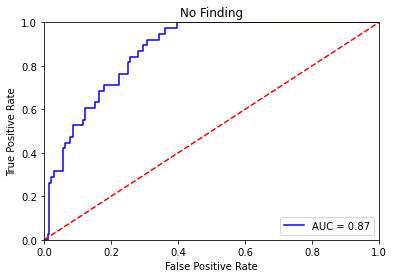

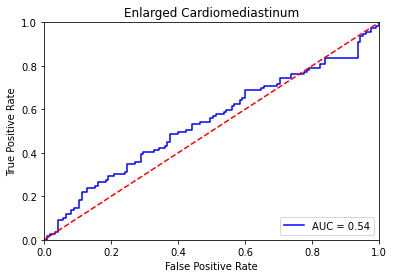

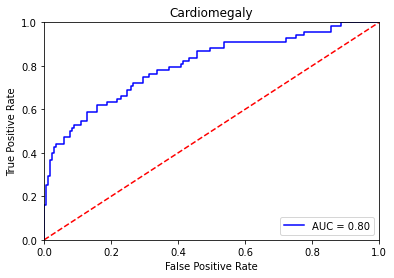

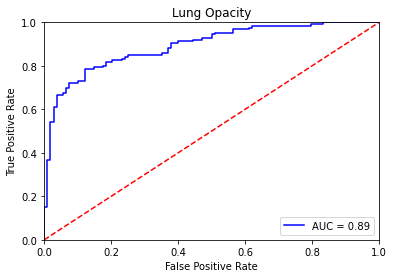

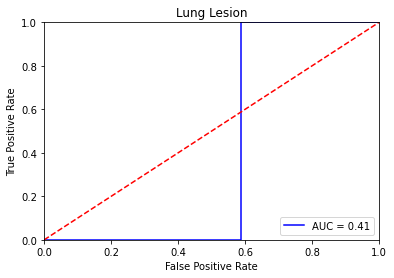

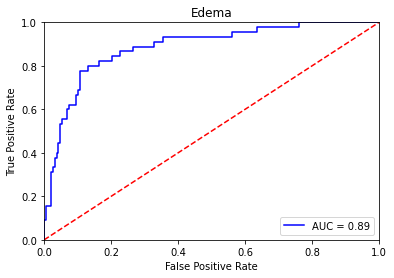

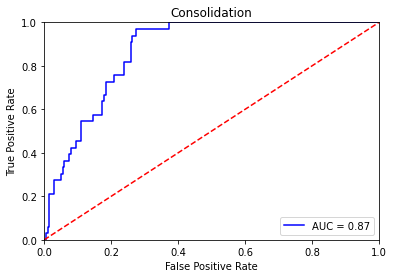

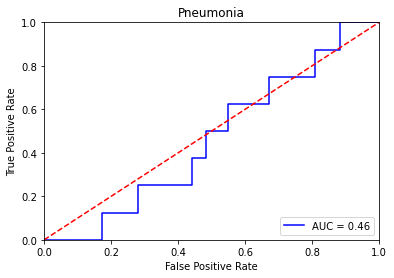

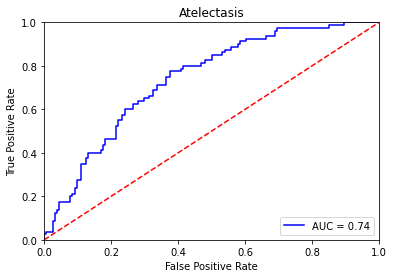

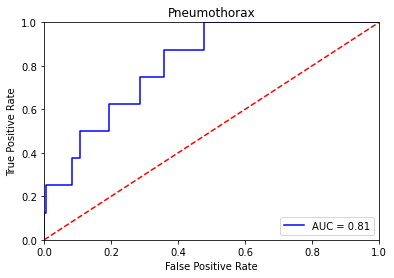

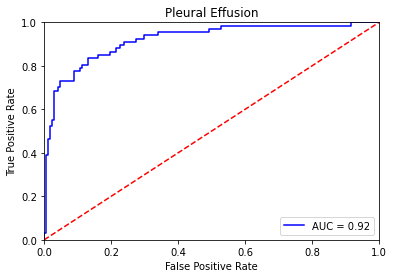

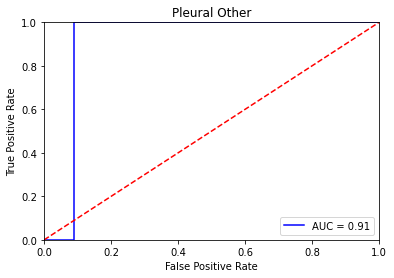

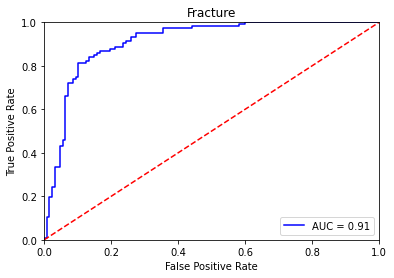

In [24]:
def plot_roc_curve(title, fpr, tpr):
    auc_curve = sklearn.metrics.auc(fpr, tpr)
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_curve)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    
plot_roc_curve("No Finding", fpr[0], tpr[0])
plot_roc_curve("Enlarged Cardiomediastinum", fpr[1], tpr[1])
plot_roc_curve("Cardiomegaly", fpr[2], tpr[2])
plot_roc_curve("Lung Opacity", fpr[3], tpr[3])
plot_roc_curve("Lung Lesion", fpr[4], tpr[4])
plot_roc_curve("Edema", fpr[5], tpr[5])
plot_roc_curve("Consolidation", fpr[6], tpr[6])
plot_roc_curve("Pneumonia", fpr[7], tpr[7])
plot_roc_curve("Atelectasis", fpr[8], tpr[8])
plot_roc_curve("Pneumothorax", fpr[9], tpr[9])
plot_roc_curve("Pleural Effusion", fpr[10], tpr[10])
plot_roc_curve("Pleural Other", fpr[11], tpr[11])
plot_roc_curve("Fracture", fpr[12], tpr[12])
